# Water Risk Classification: Data Wrangling

## Setup

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import requests, zipfile, io, os, tarfile

import rasterio as rio
from rasterio import plot
from rasterstats import zonal_stats
import rasterio.warp, rasterio.shutil
import rioxarray # for the extension to load
import xarray
import missingno as msno
from shapely.geometry import Polygon

from matplotlib import pyplot
import folium
from matplotlib import pyplot as plt
%matplotlib inline


## Download Data
**ONLY RUN IF YOU DON'T HAVE THE DATA FOLDER YET. IT WILL TAKE A LONG TIME.**

Download and unzip all the datasets. 

In [2]:
# create data folder
os.mkdir('./data')

In [4]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_aq = 'https://wri-projects.s3.amazonaws.com/Aqueduct30/finalData/Y2019M07D12_Aqueduct30_V01.zip'

r = requests.get(url_aq) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data') # unzip into data subdirectory

In [5]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_ghs = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_SMOD_POP_GLOBE_R2019A/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K/V1-0/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V1_0.zip'

r = requests.get(url_ghs) # download zipped directory
z = zipfile.ZipFile(io.BytesIO(r.content)) # create zipfile object
z.extractall(path='data/ghs') # unzip into data subdirectory

In [10]:
# This download requires useer authentication and isn't currently working
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_inf_mort = 'https://sedac.ciesin.columbia.edu/downloads/data/povmap/povmap-global-subnational-infant-mortality-rates-v2/povmap-global-subnational-infant-mortality-rates-v2-geotiff.zip'

r = requests.get(url_inf_mort) # download zipped directory
z = zipfile.ZipFile("./data/povmap-global-subnational-infant-mortality-rates-v2-geotiff.zip") # create zipfile object
z.extractall(path='data/sedac') # unzip into data subdirectory
z.close()

In [34]:
# download and extract
# DON'T RUN IF DATA IS IN ./DATA FOLDER
url_light = 'https://ngdc.noaa.gov/eog/data/web_data/v4avg_lights_x_pct/F182013.v4c.avg_lights_x_pct.tgz'

r = requests.get(url_light, allow_redirects=True)
open('./data/F182013.v4c.avg_lights_x_pct.tgz', 'wb').write(r.content)

KeyboardInterrupt: 

In [38]:
temp_path = './data/F182013.v4c.avg_lights_x_pct.tgz'

z = tarfile.open(temp_path, mode='r:gz') # create zipfile object
z.extractall(path='data/light') # unzip into data subdirectory
z.close()

os.remove(temp_path)

## Load Data

WRI Aqueduct metadata with column name explanations is available [here](https://github.com/wri/aqueduct30_data_download/blob/master/metadata.md).

In [2]:
path_aq = './data/Y2019M07D12_Aqueduct30_V01/baseline/annual/y2019m07d11_aqueduct30_annual_v01.gpkg'

aq = gpd.read_file(path_aq, layer='y2019m07d11_aqueduct30_annual_v01')

aq.head()

,string_id,aq30_id,pfaf_id,gid_1,aqid,gid_0,name_0,name_1,area_km2,bws_raw,...,w_awr_tex_rrr_score,w_awr_tex_rrr_cat,w_awr_tex_rrr_label,w_awr_tex_rrr_weight_fraction,w_awr_tex_tot_raw,w_awr_tex_tot_score,w_awr_tex_tot_cat,w_awr_tex_tot_label,w_awr_tex_tot_weight_fraction,geometry
0,111011-EGY.11_1-3365,0,111011,EGY.11_1,3365,EGY,Egypt,Al Qahirah,4.223754,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((31.90590570688292 29.85788703615783...
1,111011-EGY.15_1-3365,1,111011,EGY.15_1,3365,EGY,Egypt,As Suways,1846.012343,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((31.90256665452753 29.82957728496378...
2,111011-EGY.15_1-None,2,111011,EGY.15_1,-9999,EGY,Egypt,As Suways,30.526067,2.318042,...,2.165272,2.0,Medium - High (2-3),0.326531,2.457171,3.614603,3.0,High (3-4),0.877551,(POLYGON ((32.36609158210641 29.63378296420298...
3,111011-None-3365,3,111011,-9999,3365,None,None,None,0.742712,2.318042,...,1.133763,1.0,Low - Medium (1-2),0.163265,2.477321,3.649648,3.0,High (3-4),0.551020,(POLYGON ((32.46194054146073 29.89250514754305...
4,111011-None-None,4,111011,-9999,-9999,None,None,None,13.430995,2.318042,...,1.133763,1.0,Low - Medium (1-2),0.163265,2.477321,3.649648,3.0,High (3-4),0.551020,(POLYGON ((32.46439791820441 29.88855938783929...


In [3]:
data_cols = ['string_id', 'geometry','bws_raw', 'bwd_raw', 'iav_raw', 'sev_raw', 'gtd_raw', 'rfr_raw', 'cfr_raw', 'drr_raw', 'ucw_raw', 'udw_raw', 'usa_raw']

aq_join = aq[data_cols].copy()
aq_join.head()

,string_id,geometry,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw
0,111011-EGY.11_1-3365,(POLYGON ((31.90590570688292 29.85788703615783...,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.01057,0.023176
1,111011-EGY.15_1-3365,(POLYGON ((31.90256665452753 29.82957728496378...,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.01057,0.023176
2,111011-EGY.15_1-None,(POLYGON ((32.36609158210641 29.63378296420298...,2.318042,0.987061,1.035414,0.962396,NaN,0.074383,0.0,NaN,0.6139,0.01057,0.023176
3,111011-None-3365,(POLYGON ((32.46194054146073 29.89250514754305...,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,NaN,0.01057,0.023176
4,111011-None-None,(POLYGON ((32.46439791820441 29.88855938783929...,2.318042,0.987061,1.035414,0.962396,NaN,0.074383,0.0,NaN,NaN,0.01057,0.023176


In [4]:
path_ghs = './data/ghs/GHS_SMOD_POP2015_GLOBE_R2019A_54009_1K_V1_0.tif'

ghs = rio.open(path_ghs)

In [5]:
path_inf_mort = './data/sedac/povmap_global_subnational_infant_mortality_rates_v2.tif'

inf_mort = rio.open(path_inf_mort)

In [6]:
path_light = './data/light/F182013.v4c.avg_lights_x_pct.tif'

light = rio.open(path_light)


## Explore Data

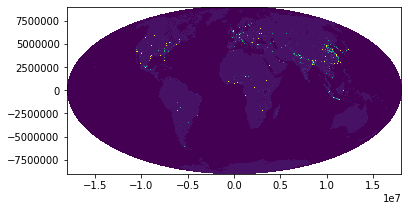

({'driver': 'GTiff',
  'dtype': 'int16',
  'nodata': -200.0,
  'width': 36082,
  'height': 18000,
  'count': 1,
  'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]'),
  'transform': Affine(1000.0, 0.0, -18041000.0,
         0.0, -1000.0, 9000000.0)},
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2bd32d50>)

In [7]:
ghs.meta,plot.show(ghs)

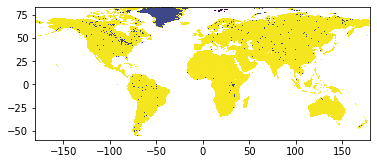

({'driver': 'GTiff',
  'dtype': 'float64',
  'nodata': -1.7976931348623157e+308,
  'width': 43200,
  'height': 17173,
  'count': 1,
  'crs': CRS.from_dict(init='epsg:4326'),
  'transform': Affine(0.00833333333333333, 0.0, -179.99999999999997,
         0.0, -0.00833333333333333, 83.62711161733333)},
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2bcf8110>)

In [8]:
inf_mort.meta,plot.show(inf_mort)

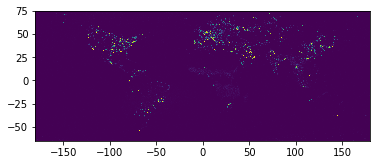

({'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': None,
  'width': 43201,
  'height': 16801,
  'count': 1,
  'crs': CRS.from_dict(init='epsg:4326'),
  'transform': Affine(0.0083333333, 0.0, -180.00416666665,
         0.0, -0.0083333333, 75.00416666665)},
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2be60750>)

In [9]:
light.meta,plot.show(light)

In [10]:
# check crs
aq.crs, aq.crs == ghs.crs, aq.crs == inf_mort.crs, aq.crs == light.crs

({'init': 'epsg:4326'}, False, True, True)

## Join Data

In [11]:
inf_mort_array = inf_mort.read(1)

In [12]:
# Need to set nodata value explicitly
mortality_stats = zonal_stats(aq_join, inf_mort_array, affine = inf_mort.transform, stats = ['mean', 'median', 'sum'])

/Users/johnmichaellasalle/anaconda3/envs/wrc/lib/python3.7/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/Users/johnmichaellasalle/anaconda3/envs/wrc/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/johnmichaellasalle/anaconda3/envs/wrc/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [13]:
aq_join['mean_infant_mort'] = [s['mean'] for s in mortality_stats]
aq_join['median_infant_mort'] = [t['median'] for t in mortality_stats]
aq_join['sum_infant_mort'] = [u['sum'] for u in mortality_stats]

aq_join.loc[np.isinf(aq_join['mean_infant_mort']) == True, 'mean_infant_mort'] = float('NaN')
aq_join.loc[np.isinf(aq_join['median_infant_mort']) == True, 'median_infant_mort'] = float('NaN')
aq_join.loc[np.isinf(aq_join['sum_infant_mort']) == True, 'sum_infant_mort'] = float('NaN')

In [14]:
# over half of all infant mortality rates are negative, which can't be right
a = aq_join['mean_infant_mort'] >= 0
a.value_counts()

False    38487
True     30019
Name: mean_infant_mort, dtype: int64

In [15]:
light_array = light.read(1)

In [16]:
light_stats = zonal_stats(aq_join, light_array, affine = light.transform, stats = ['mean', 'median'])

In [17]:
aq_join['mean_light'] = [s['mean'] for s in light_stats]
aq_join['median_light'] = [t['median'] for t in light_stats]

aq_join.loc[np.isinf(aq_join['mean_light']) == True, 'mean_light'] = float('NaN')
aq_join.loc[np.isinf(aq_join['median_light']) == True, 'median_light'] = float('NaN')

# aq_join.head(10)

In [18]:
# instead of repreojecting the raster, I reprojected the aquifer data to the ghs crs
aq_join = aq_join.to_crs(ghs.crs.data)

In [19]:
ghs_array = ghs.read(1)

In [20]:
ghs_stats = zonal_stats(aq_join, ghs_array, affine = ghs.transform, stats = ['sum'])

In [21]:
aq_join['sum_pop'] = [u['sum'] for u in ghs_stats]

# aq_join.loc[np.isinf(aq_join['sum_pop']) == True, 'sum_pop'] = float('NaN')

In [22]:
aq_join = aq_join.to_crs(aq.crs)

In [23]:
aq_join.head(10)

,string_id,geometry,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,ucw_raw,udw_raw,usa_raw,mean_infant_mort,median_infant_mort,sum_infant_mort,mean_light,median_light,sum_pop
0,111011-EGY.11_1-3365,(POLYGON ((31.90590570688292 29.85788703615783...,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.010570,0.023176,3.469315e+01,3.469315e+01,1.734658e+02,2.522154,1.865672,55.0
1,111011-EGY.15_1-3365,(POLYGON ((31.90256665452753 29.82957728496378...,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,0.6139,0.010570,0.023176,1.486849e+01,1.486849e+01,3.665084e+04,13.672038,3.063492,20971.0
2,111011-EGY.15_1-None,(POLYGON ((32.36609158210641 29.63378296420297...,2.318042,0.987061,1.035414,0.962396,NaN,0.074383,0.0,NaN,0.6139,0.010570,0.023176,NaN,1.486849e+01,NaN,36.785975,38.500000,448.0
3,111011-None-3365,(POLYGON ((32.46194054146073 29.89250514754306...,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,NaN,0.010570,0.023176,1.486849e+01,1.486849e+01,1.486849e+01,35.409092,35.409092,NaN
4,111011-None-None,"(POLYGON ((32.4643979182044 29.88855938783929,...",2.318042,0.987061,1.035414,0.962396,NaN,0.074383,0.0,NaN,NaN,0.010570,0.023176,NaN,1.486849e+01,NaN,38.731335,43.783699,187.0
5,111012-EGY.11_1-3365,(POLYGON ((31.88750000022489 29.85833333371637...,1.000000,1.000000,1.161367,1.027464,0.843958,0.000000,0.0,NaN,0.6139,0.016651,0.045942,3.469315e+01,3.469315e+01,1.207322e+04,1.453173,0.369231,2827.0
6,111012-EGY.15_1-3365,(POLYGON ((31.89332770960626 29.73370743035362...,1.000000,1.000000,1.161367,1.027464,0.843958,0.000000,0.0,NaN,0.6139,0.016651,0.045942,1.493707e+01,1.486849e+01,4.318306e+04,2.134491,0.138462,23830.0
7,111012-EGY.15_1-None,(POLYGON ((32.36609158210641 29.63378296420297...,1.000000,1.000000,1.161367,1.027464,NaN,0.000000,0.0,NaN,0.6139,0.016651,0.045942,-8.988466e+307,-8.988466e+307,-1.797693e+308,56.376812,56.376812,34.0
8,111012-EGY.8_1-3365,(POLYGON ((31.74570583035987 29.75178815260122...,1.000000,1.000000,1.161367,1.027464,0.843958,0.000000,0.0,NaN,0.6139,0.016651,0.045942,3.469315e+01,3.469315e+01,2.369542e+04,0.341185,0.149254,5632.0
9,111012-None-None,(POLYGON ((32.36456566737174 29.62904440887238...,1.000000,1.000000,1.161367,1.027464,NaN,0.000000,0.0,NaN,NaN,0.016651,0.045942,NaN,NaN,NaN,NaN,NaN,NaN


/Users/johnmichaellasalle/anaconda3/envs/wrc/lib/python3.7/site-packages/matplotlib/colors.py:479: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


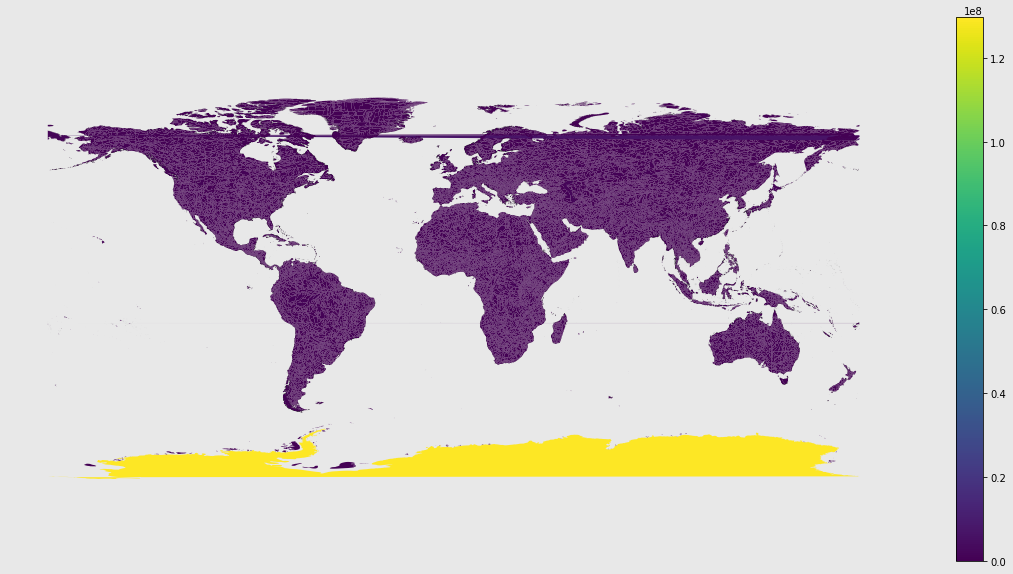

In [24]:
fig, ax = plt.subplots(figsize=(20,10), facecolor='#E8E8E8')
aq_join.plot(ax = ax, column = 'sum_pop', legend=True)
ax.set_axis_off()

# it doesn't look good

## Engineer Features

In [25]:
# project to equal area projection to calculate densities
# NSIDC EASE-Grid 2.0 Global Equal area to calculate densities, https://epsg.io/6933

aq_proj = aq_join.to_crs({'init':'epsg:6933'})

In [26]:
# Calculate the area of each Aqueduct polygon
aq_proj['area_sqkm'] = aq_proj.area/10000000

# Calculate population density
aq_proj['pop_density'] = aq_proj['sum_pop']/aq_proj['area_sqkm']

# reclassify NAs as zero
aq_proj.loc[np.isnan(aq_proj['pop_density']) == True, 'pop_density'] = 0

In [27]:
aq_proj

,string_id,geometry,bws_raw,bwd_raw,iav_raw,sev_raw,gtd_raw,rfr_raw,cfr_raw,drr_raw,...,udw_raw,usa_raw,mean_infant_mort,median_infant_mort,sum_infant_mort,mean_light,median_light,sum_pop,area_sqkm,pop_density
0,111011-EGY.11_1-3365,(POLYGON ((3078482.159692984 3643024.719021467...,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,...,0.01057,0.023176,34.693151,34.693151,173.465753,2.522154,1.865672,55.0,0.427536,128.644016
1,111011-EGY.15_1-3365,(POLYGON ((3078159.986951649 3639881.683470111...,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,...,0.01057,0.023176,14.868493,14.868493,36650.835616,13.672038,3.063492,20971.0,184.007398,113.968244
2,111011-EGY.15_1-None,(POLYGON ((3122883.783017301 3618120.150661286...,2.318042,0.987061,1.035414,0.962396,NaN,0.074383,0.0,NaN,...,0.01057,0.023176,NaN,14.868493,NaN,36.785975,38.500000,448.0,3.012712,148.703222
3,111011-None-3365,(POLYGON ((3132131.892571319 3646866.941043749...,2.318042,0.987061,1.035414,0.962396,0.843958,0.074383,0.0,NaN,...,0.01057,0.023176,14.868493,14.868493,14.868493,35.409092,35.409092,NaN,0.056887,0.000000
4,111011-None-None,(POLYGON ((3132368.995712492 3646429.071968127...,2.318042,0.987061,1.035414,0.962396,NaN,0.074383,0.0,NaN,...,0.01057,0.023176,NaN,14.868493,NaN,38.731335,43.783699,187.0,1.342419,139.300793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68501,None-YEM.5_1-None,(POLYGON ((4141414.755337685 1885180.259790602...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.283582,0.283582,NaN,0.077496,0.000000
68502,None-ZAF.1_1-None,(POLYGON ((2425183.705530331 -4089146.33674417...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001947,0.000000
68503,None-ZAF.4_1-None,(POLYGON ((3096387.71692846 -3526673.809948078...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.003126,0.000000
68504,None-ZAF.9_1-2940,(POLYGON ((2177937.675617851 -4092687.35828992...,NaN,NaN,NaN,NaN,0.000600,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001537,0.000000


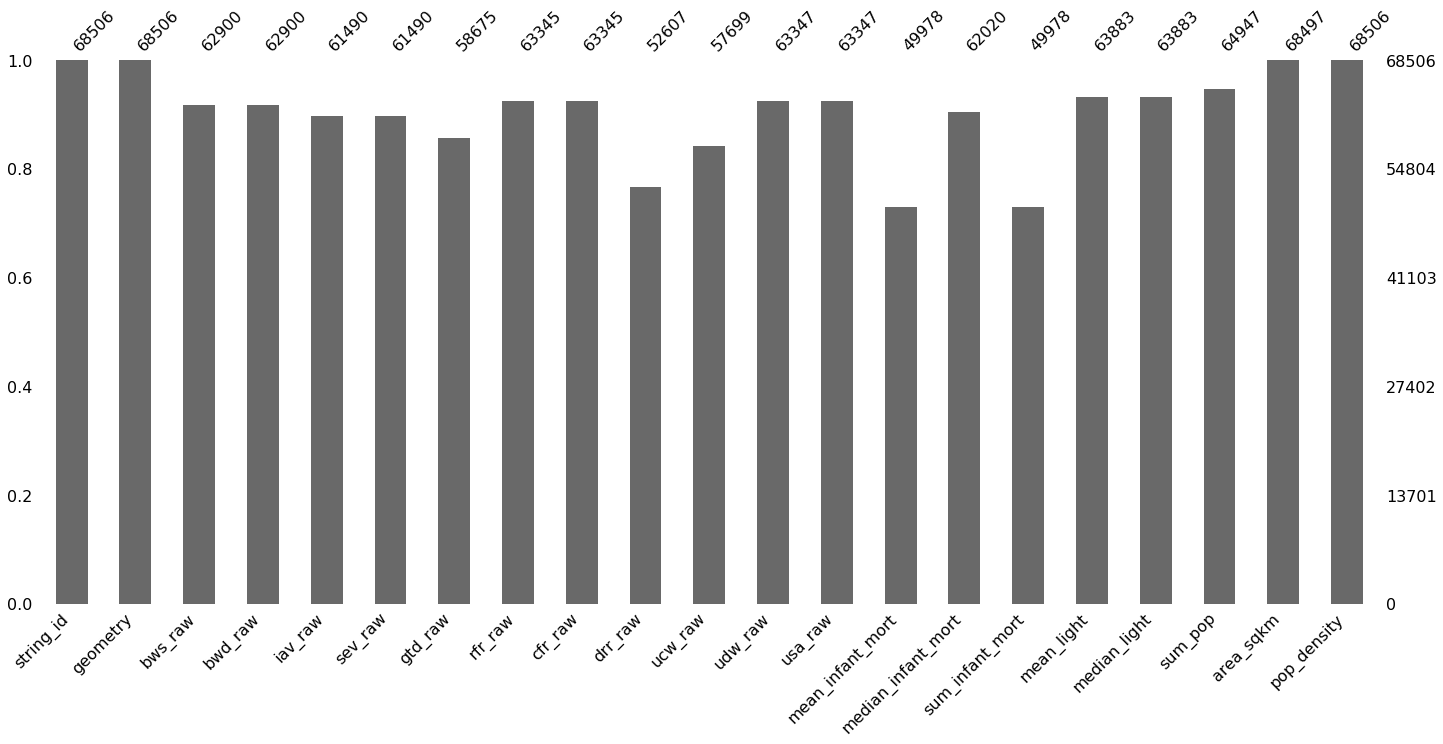

In [28]:
msno.bar(aq_proj)

In [29]:
# Drop rows with missing values
aq_filtered = aq_proj.dropna()

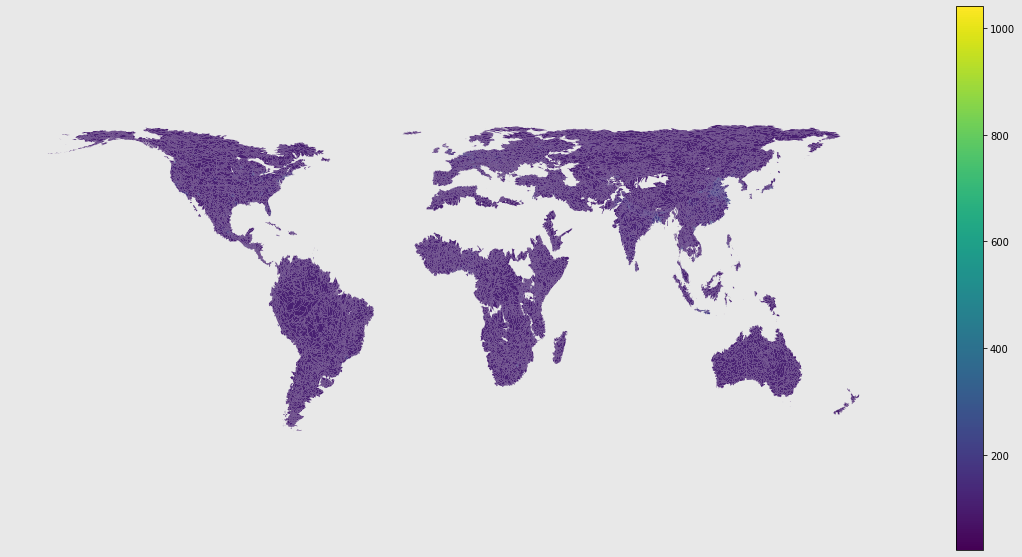

In [30]:
# This approach doesn't work. Need to find a better way to handle NAs
fig, ax = plt.subplots(figsize=(20,10), facecolor='#E8E8E8')
aq_filtered.plot(ax = ax, column = 'pop_density', legend=True)
ax.set_axis_off()

## Save GeoJSON for Modeling

In [32]:
# Need to decide on what point to export at
aq_proj.to_crs(aq_join.crs).to_file("./data/data.geojson", driver='GeoJSON')